In [1]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.simplefilter(action="ignore")

In [2]:
# Set option settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# Reading the dataset
df = pd.read_csv("diabetes.csv")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# 1. EDA (Exploratory Data Analysis)

In [5]:
# We are looking at the basic information of the dataset
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Info #####################")
    print(dataframe.info())
    print("##################### Columns #####################")
    print(dataframe.columns)
    print("##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Duplicate #####################")
    print(dataframe.duplicated().sum())
    print("##################### Count of Unique Values #####################")
    print(dataframe.nunique())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(768, 9)
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
##################### Columns #####################
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin

"""
1) We have 768 values and 8 variables.
2) All of our variables except Outcome are numeric.
3) The data set has 9 columns.
4) There are no missing values
5) There are no duplicated values.
6) When we look at the unique values of our variables, we see two unique values in the outcome variable.
The outcome variable may be our target variable.
7) When we look at the percentile values of our numerical variables, we see some outliers.
For example, a person's glucose value cannot be 0. We should perform outlier analysis.

"""

In [7]:
# We are identifying numerical and categorical variables
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [8]:
# The unique values of the target variable
df["Outcome"].unique()

array([1, 0], dtype=int64)

In [9]:
"""
1 represents diabetic individuals and 0 represents non-diabetic individuals.

"""

'\n1 represents diabetic individuals and 0 represents non-diabetic individuals.\n\n'

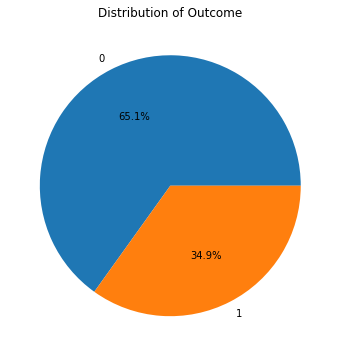

Proportions of Outcome:
0   65.104
1   34.896
Name: Outcome, dtype: float64


In [10]:
# Plot target variable
def plot_target_variable(data, target_variable):
    """
    Plot the target variable along with its proportions.
    
    Parameters:
    - data: DataFrame, the dataset containing the target variable
    - target_variable: str, the name of the target variable
    
    """
    plt.figure(figsize=(8, 6))
    df['Outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.ylabel('')
    plt.title(f'Distribution of Outcome')
    plt.show()
    
    proportions = df[target_variable].value_counts(normalize=True) * 100
    print(f'Proportions of {target_variable}:')
    print(proportions)

# Plot the target variable "Outcome"
plot_target_variable(df, 'Outcome')

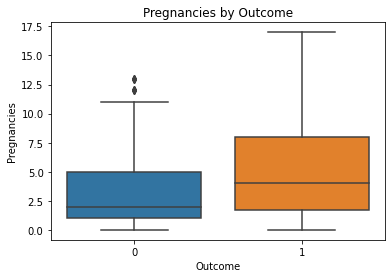

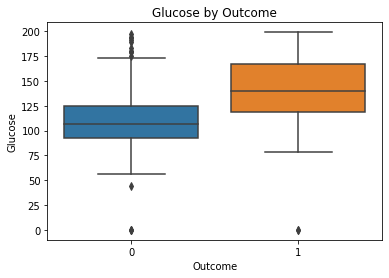

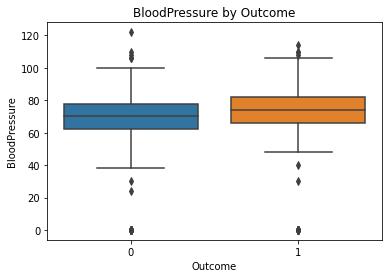

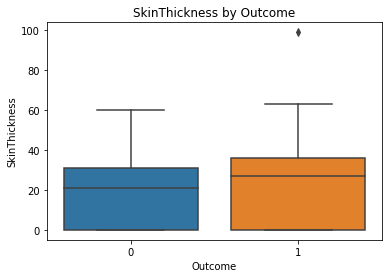

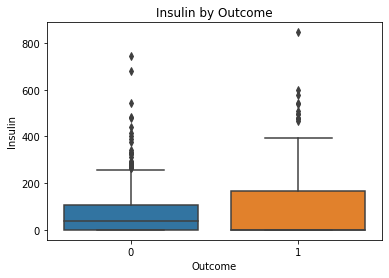

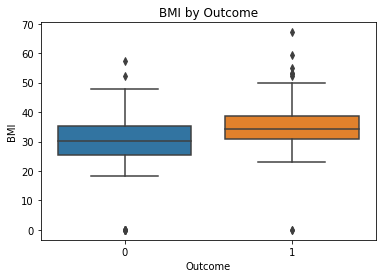

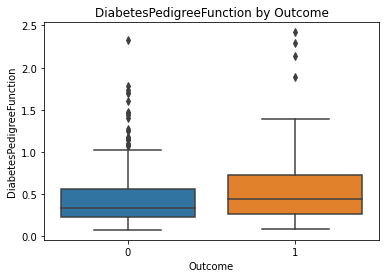

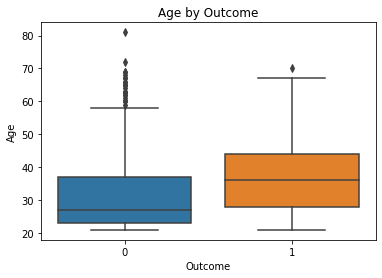

In [11]:
# Explore the relationship between numerical variables and the target variable
for col in num_cols:
    sns.boxplot(x=df['Outcome'], y=df[col])
    plt.xlabel('Outcome')
    plt.ylabel(col)
    plt.title(f'{col} by Outcome')
    plt.show()

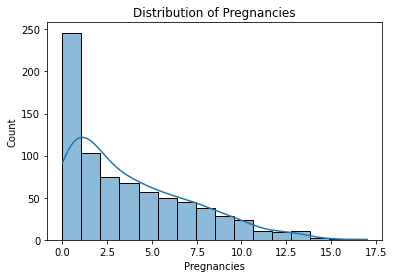

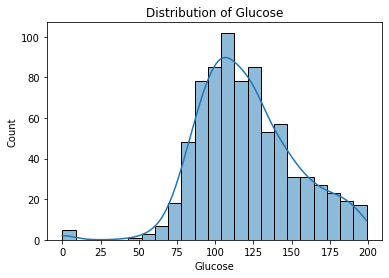

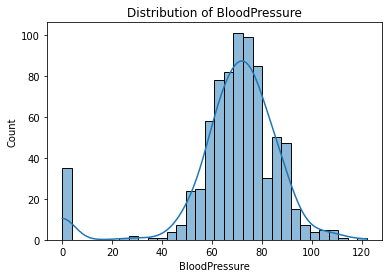

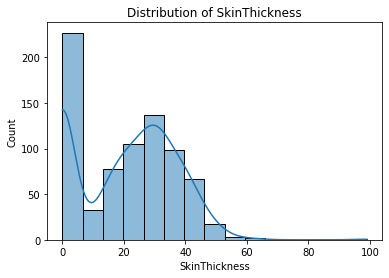

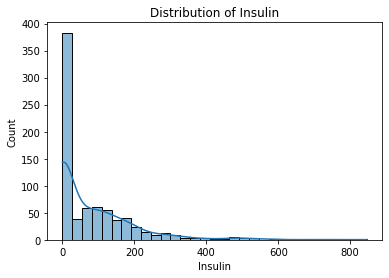

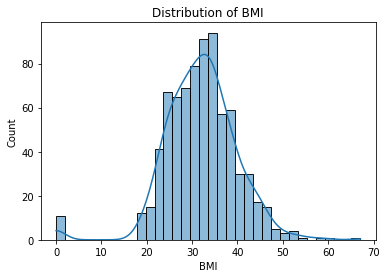

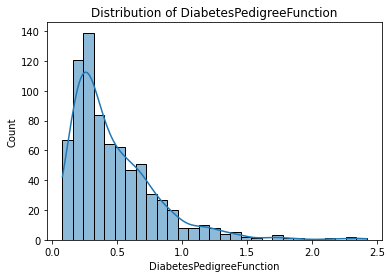

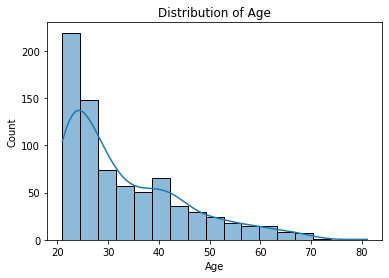

In [12]:
# Explore the distribution of numerical variables
for col in num_cols:
    sns.histplot(df[col], kde=True)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution of {col}')
    plt.show()

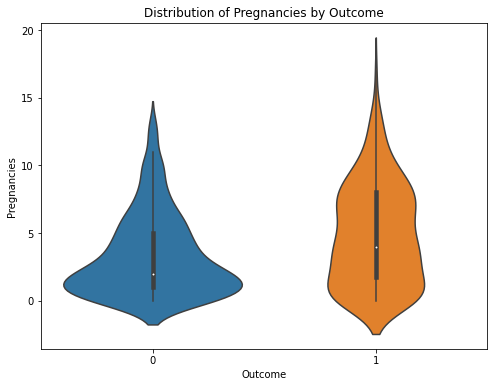

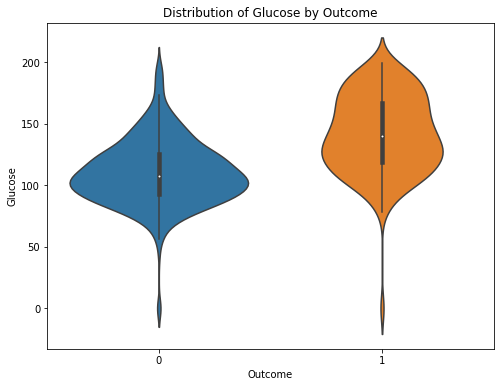

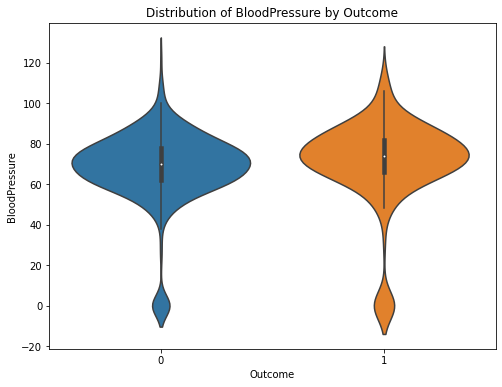

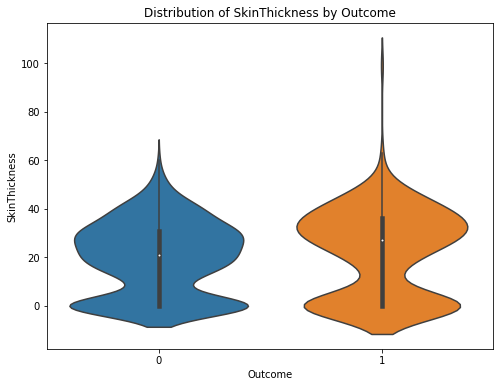

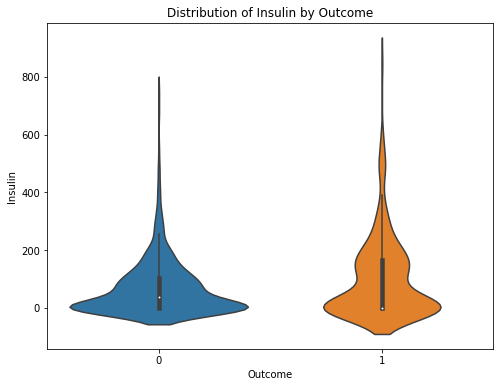

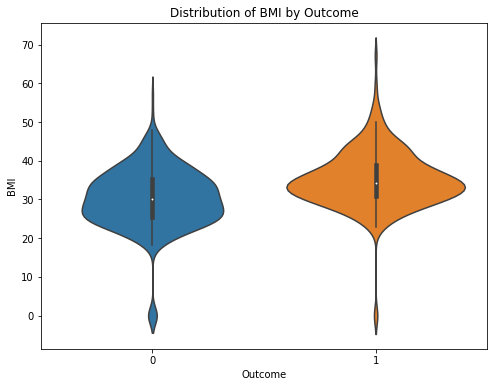

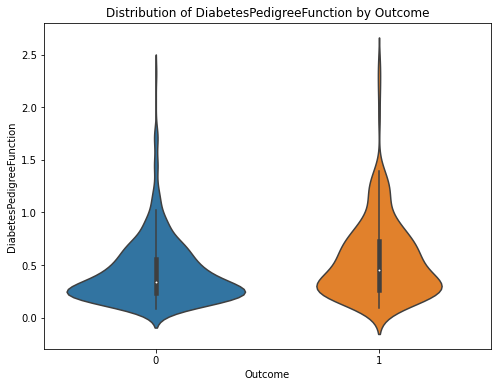

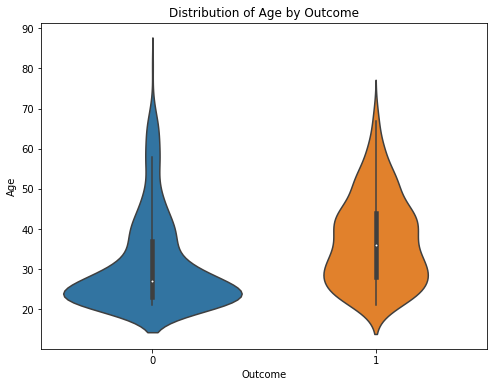

In [13]:
# Distribution of numeric columns by target variable
def generate_grouped_violin_plots(data, target_var):
    """
    Generate grouped violin plots to compare the distribution of the numerical variables
    across different categories of the target variable.
    
    Parameters:
    - data: DataFrame, the dataset containing the variables
    - target_var: str, the name of the target variable
    
    """
    
    for col in num_cols:
        plt.figure(figsize=(8, 6))
        sns.violinplot(x=df[target_var], y=df[col])
        plt.xlabel(target_var)
        plt.ylabel(col)
        plt.title(f'Distribution of {col} by {target_var}')
        plt.show()

generate_grouped_violin_plots(df, 'Outcome')

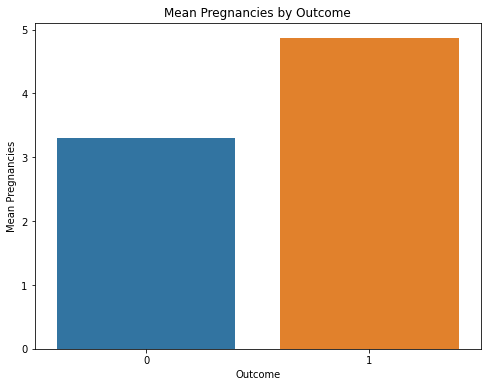

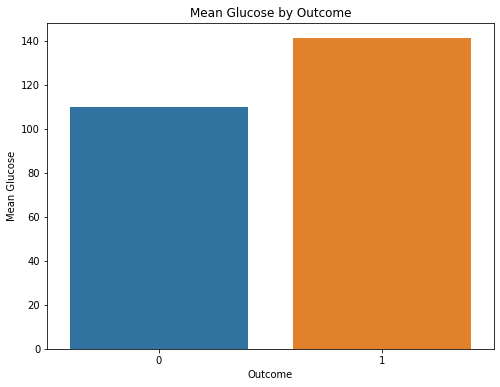

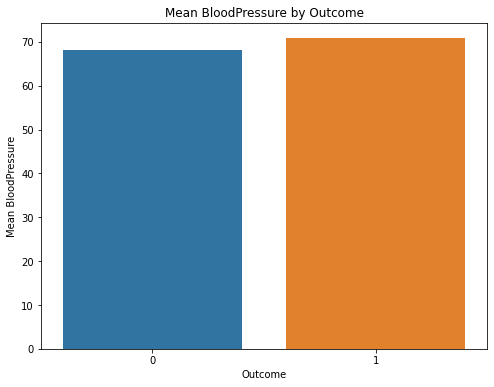

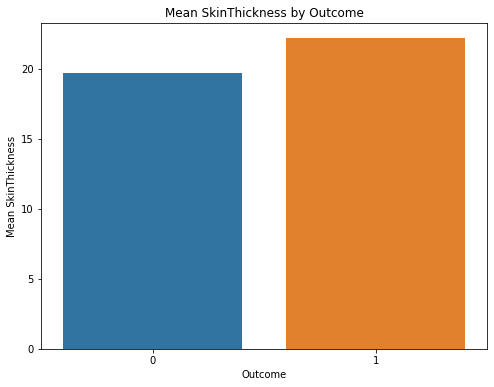

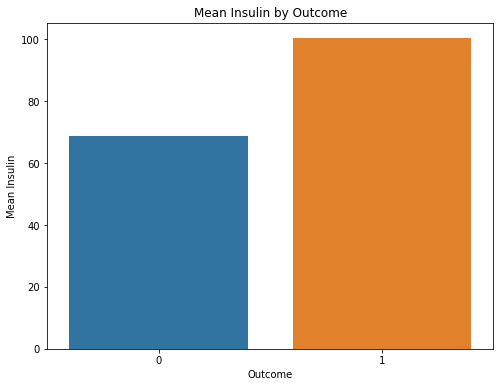

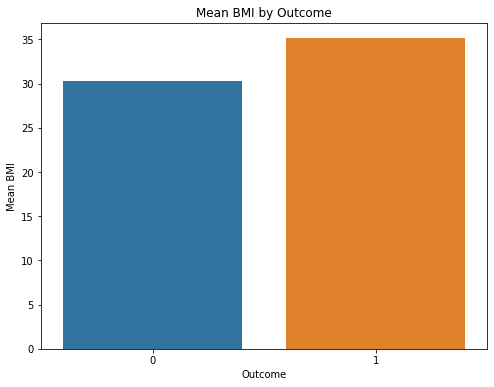

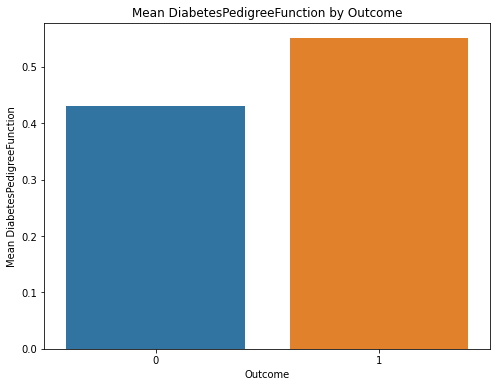

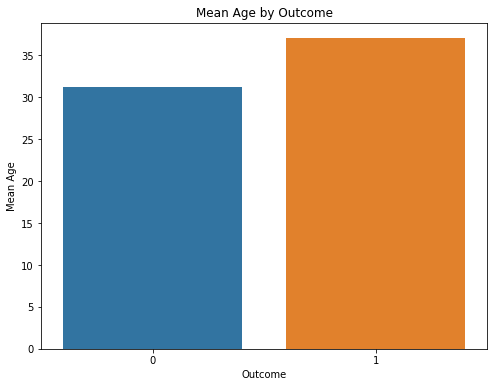

In [14]:
# Grouped Bar Plot
def generate_grouped_bar_plots(data, target_var):
    """
    Generate grouped bar plots to compare the mean value of the target variable
    across different categories of all numerical variables in the dataset.
    
    Parameters:
    - data: DataFrame, the dataset containing the variables
    - target_var: str, the name of the target variable
    
    """
    
    for col in num_cols:
        plt.figure(figsize=(8, 6))
        grouped_data = df.groupby(target_var)[col].mean().reset_index()
        sns.barplot(x=target_var, y=col, data=grouped_data)
        plt.xlabel(target_var)
        plt.ylabel(f'Mean {col}')
        plt.title(f'Mean {col} by {target_var}')
        plt.show()

generate_grouped_bar_plots(df, 'Outcome')

In [15]:
# Analysis of numerical variables
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

for col in num_cols:
    num_summary(df, col)

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64
count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64
count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64
count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10% 

In [16]:
# Correlation analysis
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


In [17]:
"""
The variables all have a positive correlation with the target variable.
The "Glucose" variable is the variable with the highest positive correlation with the target variable.
The blood pressure variable has the lowest positive correlation with the target variable.

"""

'\nThe variables all have a positive correlation with the target variable.\nThe "Glucose" variable is the variable with the highest positive correlation with the target variable.\nThe blood pressure variable has the lowest positive correlation with the target variable.\n\n'

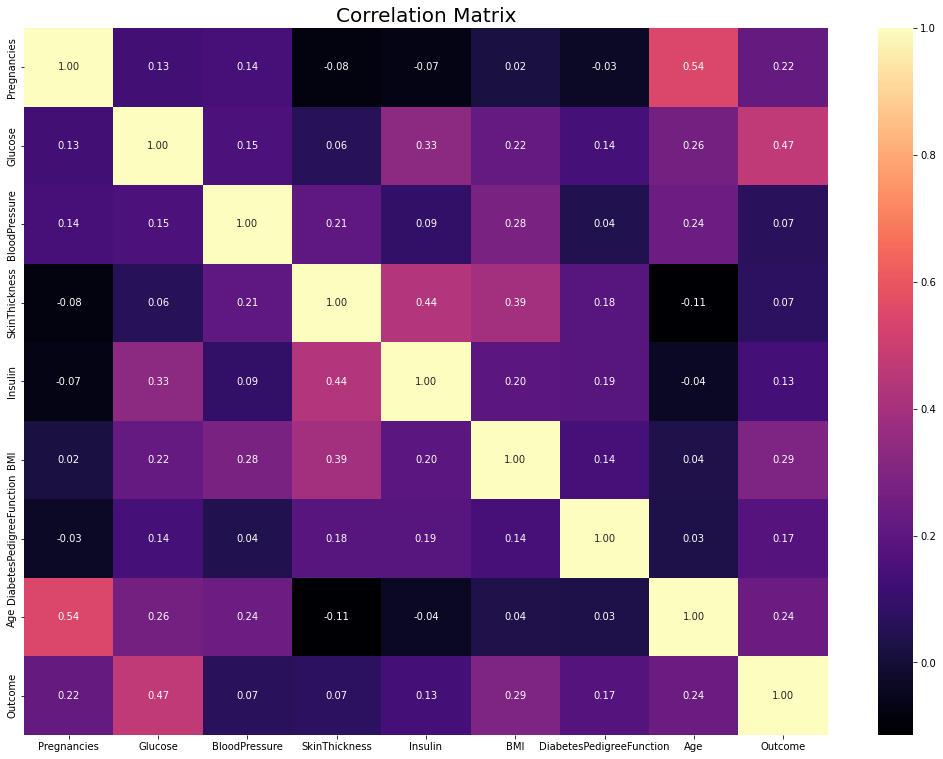

In [18]:
# Correlation matrix
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [19]:
"""
Base Model's Predictions

"""
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

models = [('KNN', KNeighborsClassifier())]

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")

########## KNN ##########
Accuracy: 0.724
F1: 0.5705
Auc: 0.7486


# 2. DATA PRE-PROCESSING AND FEATURE ENGINEERING

In [21]:
# Quartile distributions of numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [22]:
# Variables whose minimum values cannot be equal to 0.
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [23]:
# We are replacing the 0 values in the variables values with NaN.
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])
    
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [24]:
# We complete the missing values with the median values of their own variables
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [25]:
# Now we can analyze the numeric variables better.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,121.656,30.438,44.000,99.750,117.000,140.250,199.000
BloodPressure,768.000,72.387,12.097,24.000,64.000,72.000,80.000,122.000
SkinThickness,768.000,29.108,8.791,7.000,25.000,29.000,32.000,99.000
Insulin,768.000,140.672,86.383,14.000,121.500,125.000,127.250,846.000
BMI,768.000,32.455,6.875,18.200,27.500,32.300,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [26]:
# Outlier Analysis
def outlier_thresholds(dataframe, col_name, q1=0.20, q3=0.80):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


In [27]:
"""
In the outlier analysis, we only found outlier values in the insulin variable.
However, as mentioned above, the minimum value of other variables cannot be 0.
It is possible that values that should be NaN have been filled with 0.
"""

'\nIn the outlier analysis, we only found outlier values in the insulin variable.\nHowever, as mentioned above, the minimum value of other variables cannot be 0.\nIt is possible that values that should be NaN have been filled with 0.\n'

In [28]:
# We are replacing the outliers according to the IQR method.
def replace_with_thresholds(dataframe, variable, q1=0.20, q3=0.80):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.20, q3=0.80)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in num_cols:
    replace_with_thresholds(df, col)

In [29]:
# We are checking the outlier analysis again for control
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [30]:
# Calculating the number of missing values for each variable
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

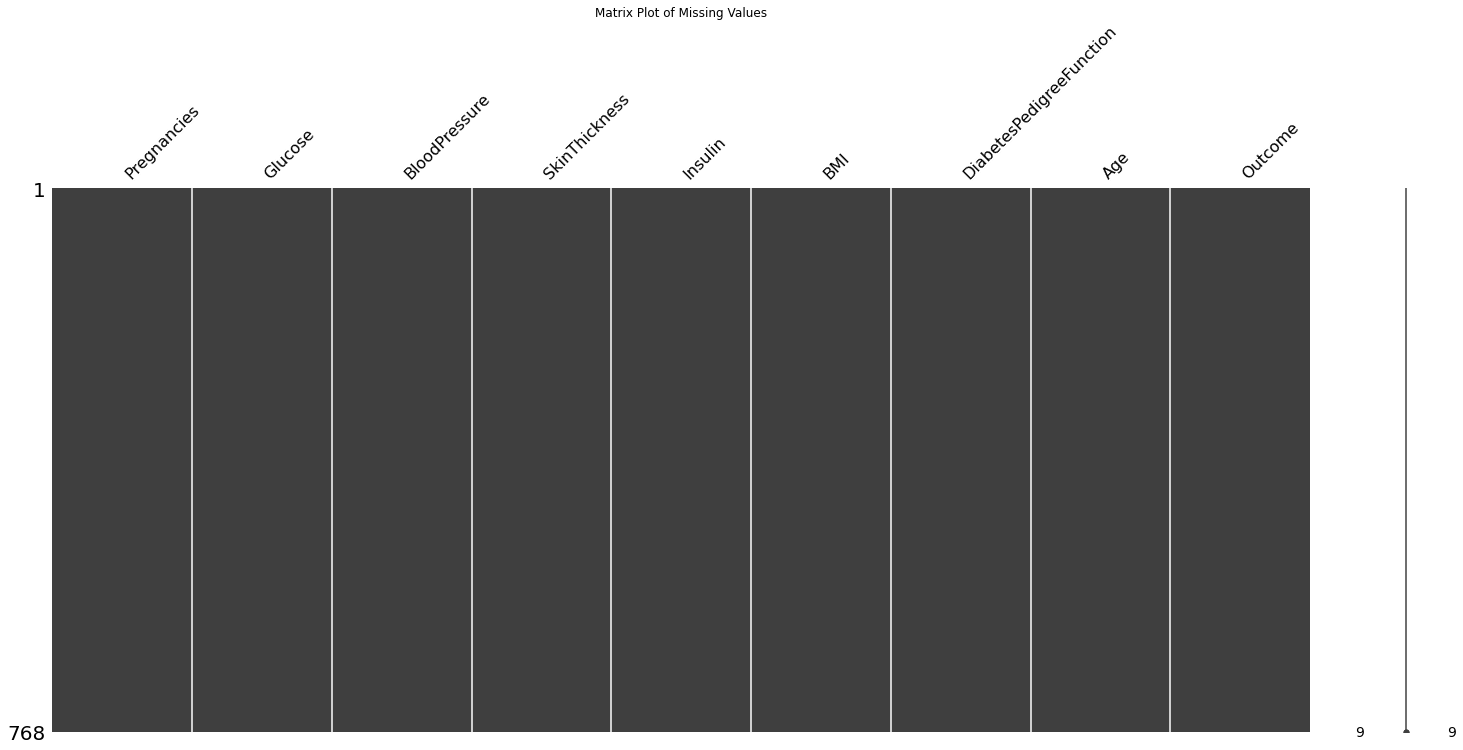

In [31]:
# Creating the matrix plot using msno.matrix() method
msno.matrix(df)

# Customizing the plot using matplotlib
plt.title('Matrix Plot of Missing Values')
plt.show()

In [32]:
df.to_csv("diabetes_clean.csv")

In [33]:
"""
FEATURE EXTRACTION

"""
# Glucose level
glucose_bins = [0, 70, 100, float('inf')]
glucose_labels = ['Low', 'Normal', 'High']

df['Glucose_Level'] = pd.cut(df['Glucose'], bins=glucose_bins, labels=glucose_labels)

# BMI category
bmi_bins = [0, 18.5, 25, 30, 35, 40, float('inf')]
bmi_labels = ['underweight', 'normal', 'overweight', 'obese class I', 'obese class II', 'obese class III']
df['bmi_category'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels)

# Create a new column with the interaction between glucose and BMI
df['Glucose and BMI Interaction'] = df['Glucose'] * df['BMI']

# Create a new column with blood sugar level category
bsl_ranges = [0, 80, 140, np.inf]
bsl_labels = ['Normal', 'High', 'Very High']

df['Blood Sugar Level'] = pd.cut(df['Glucose'], bins=bsl_ranges, labels=bsl_labels)

# Create a new feature for insulin category
df['Insulin_Category'] = pd.cut(df['Insulin'], bins=[-1, 50, 200, 1000], labels=['Low', 'Normal', 'High'])

# Create age and BMI interaction feature
df["Age_BMI_Interaction"] = df["Age"] * df["BMI"]

# Age Difference
average_age = df['Age'].mean()
df['Age_Difference'] = df['Age'] - average_age

# Create diabetes history feature
dpf_threshold = 0.8
df["Diabetes_History"] = df["DiabetesPedigreeFunction"].apply(lambda x: "Yes" if x >= dpf_threshold else "No")

# Calculate Insulin-Glucose Ratio feature
df["Insulin_Glucose_Ratio"] = df["Insulin"] / df["Glucose"]

# Risk score
features = ['Glucose', 'BMI', 'Age', 'Insulin', 'BloodPressure']
weights = [0.2, 0.25, 0.2, 0.15, 0.2]

df['risk_score'] = (df[features] * weights).sum(axis=1)

# Glucose Level Classification
df['Glucose_Level'] = pd.cut(df['Glucose'], bins=[0, 70, 99, float('inf')],
                             labels=['Low Glucose', 'Normal Glucose', 'High Glucose'])

# Insulin Level Classification
df['Insulin_Level'] = pd.cut(df['Insulin'], bins=[0, 30, 199, float('inf')],
                             labels=['Low Insulin', 'Normal Insulin', 'High Insulin'])

# Mean Encoding
mean_encoding = df.groupby('BMI')['Outcome'].mean()
df['BMI_Category_Mean_Encoding'] = df['BMI'].map(mean_encoding)

# For insulin
mean_encoding = df.groupby('Insulin')['Outcome'].mean()
df['Insulin_Level_Mean_Encoding'] = df['Insulin'].map(mean_encoding)

# For glucose
mean_encoding = df.groupby('Glucose')['Outcome'].mean()
df['Glucose_Level_Mean_Encoding'] = df['Glucose'].map(mean_encoding)

# For blood pressure
mean_encoding = df.groupby('BloodPressure')['Outcome'].mean()
df['BloodPressure_Level_Mean_Encoding'] = df['BloodPressure'].map(mean_encoding)

# For diabetes pedigree function
mean_encoding = df.groupby('DiabetesPedigreeFunction')['Outcome'].mean()
df['DiabetesPedigreeFunction_Level_Mean_Encoding'] = df['DiabetesPedigreeFunction'].map(mean_encoding)

# For age
mean_encoding = df.groupby('Age')['Outcome'].mean()
df['Age_Level_Mean_Encoding'] = df['Age'].map(mean_encoding)

# For skin thickness
mean_encoding = df.groupby('SkinThickness')['Outcome'].mean()
df['SkinThickness_Level_Mean_Encoding'] = df['SkinThickness'].map(mean_encoding)

df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_Level,bmi_category,Glucose and BMI Interaction,Blood Sugar Level,Insulin_Category,Age_BMI_Interaction,Age_Difference,Diabetes_History,Insulin_Glucose_Ratio,risk_score,Insulin_Level,BMI_Category_Mean_Encoding,Insulin_Level_Mean_Encoding,Glucose_Level_Mean_Encoding,BloodPressure_Level_Mean_Encoding,DiabetesPedigreeFunction_Level_Mean_Encoding,Age_Level_Mean_Encoding,SkinThickness_Level_Mean_Encoding
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,High Glucose,obese class I,4972.800,Very High,Normal,1680.000,16.771,No,0.845,81.150,Normal Insulin,0.500,0.370,0.750,0.405,1.000,0.625,0.533
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,Normal Glucose,overweight,2261.000,High,Normal,824.600,-2.229,No,1.471,61.800,Normal Insulin,0.250,0.370,0.143,0.367,0.000,0.542,0.389
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,High Glucose,normal,4263.900,Very High,Normal,745.600,-1.229,No,0.683,80.375,Normal Insulin,0.500,0.370,0.667,0.302,1.000,0.562,0.389
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,Normal Glucose,overweight,2500.900,High,Normal,590.100,-12.229,No,1.056,56.325,Normal Insulin,0.000,0.000,0.000,0.367,0.000,0.079,0.182
4,0,137.000,40.000,35.000,168.000,43.100,1.388,33.000,1,High Glucose,obese class III,5904.700,High,Normal,1422.300,-0.229,Yes,1.226,77.975,Normal Insulin,1.000,0.500,0.250,1.000,0.412,0.588,0.533


In [34]:
# Data types of all variables, including the new variables
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 27
cat_cols: 8
num_cols: 19
cat_but_car: 0
num_but_cat: 7


In [35]:
# We remove our dependent variable from the cat_cols list before applying one-hot encoding.
cat_cols = [col for col in cat_cols if col not in ["Outcome"]]

In [36]:
# One-Hot Encoding Process
# One-hot encoding is a process of converting categorical data into a binary vector representation.
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [37]:
df[num_cols].iloc[[-1]]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Glucose and BMI Interaction,Age_BMI_Interaction,Age_Difference,Insulin_Glucose_Ratio,risk_score,BMI_Category_Mean_Encoding,Insulin_Level_Mean_Encoding,Glucose_Level_Mean_Encoding,BloodPressure_Level_Mean_Encoding,Age_Level_Mean_Encoding,SkinThickness_Level_Mean_Encoding
767,1,93.000,70.000,31.000,125.000,30.400,0.315,23.000,2827.200,699.200,-10.229,1.344,63.550,0.571,0.370,0.143,0.404,0.184,0.316


In [38]:
# Standardization for numerical variables
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Glucose and BMI Interaction,Age_BMI_Interaction,Age_Difference,Insulin_Glucose_Ratio,risk_score,BMI_Category_Mean_Encoding,Insulin_Level_Mean_Encoding,Glucose_Level_Mean_Encoding,BloodPressure_Level_Mean_Encoding,Age_Level_Mean_Encoding,SkinThickness_Level_Mean_Encoding
0,0.600,0.765,0.000,0.857,0.000,0.143,0.665,1.235,0.652,1.131,1.235,-0.487,0.492,0.286,0.000,1.400,0.271,0.931,1.389
1,-0.400,-0.790,-0.375,0.000,0.000,-0.626,-0.056,0.118,-0.794,-0.266,0.118,0.933,-0.583,-0.214,0.000,-0.300,-0.075,0.702,0.000
2,1.000,1.630,-0.500,0.000,0.000,-0.989,0.783,0.176,0.274,-0.395,0.176,-0.854,0.449,0.286,0.000,1.167,-0.655,0.759,0.000
3,-0.400,-0.691,-0.375,-0.857,-5.391,-0.462,-0.537,-0.471,-0.666,-0.649,-0.471,-0.007,-0.887,-0.714,-10.000,-0.700,-0.075,-0.566,-2.003
4,-0.600,0.494,-2.000,0.857,7.478,1.187,2.656,0.235,1.148,0.710,0.235,0.379,0.316,1.286,3.500,0.000,5.633,0.830,1.389


In [39]:
# After Data Preprocessing and Feature Engineering
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose and BMI Interaction,Age_BMI_Interaction,Age_Difference,Insulin_Glucose_Ratio,risk_score,BMI_Category_Mean_Encoding,Insulin_Level_Mean_Encoding,Glucose_Level_Mean_Encoding,BloodPressure_Level_Mean_Encoding,Age_Level_Mean_Encoding,SkinThickness_Level_Mean_Encoding,Diabetes_History_Yes,Glucose_Level_Normal Glucose,Glucose_Level_High Glucose,bmi_category_normal,bmi_category_overweight,bmi_category_obese class I,bmi_category_obese class II,bmi_category_obese class III,Blood Sugar Level_High,Blood Sugar Level_Very High,Insulin_Category_Normal,Insulin_Category_High,Insulin_Level_Normal Insulin,Insulin_Level_High Insulin,DiabetesPedigreeFunction_Level_Mean_Encoding_0.25,DiabetesPedigreeFunction_Level_Mean_Encoding_0.3333333333333333,DiabetesPedigreeFunction_Level_Mean_Encoding_0.4,DiabetesPedigreeFunction_Level_Mean_Encoding_0.4117647058823529,DiabetesPedigreeFunction_Level_Mean_Encoding_0.5,DiabetesPedigreeFunction_Level_Mean_Encoding_0.6666666666666666,DiabetesPedigreeFunction_Level_Mean_Encoding_1.0
0,0.600,0.765,0.000,0.857,0.000,0.143,0.665,1.235,1,0.652,1.131,1.235,-0.487,0.492,0.286,0.000,1.400,0.271,0.931,1.389,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1
1,-0.400,-0.790,-0.375,0.000,0.000,-0.626,-0.056,0.118,0,-0.794,-0.266,0.118,0.933,-0.583,-0.214,0.000,-0.300,-0.075,0.702,0.000,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
2,1.000,1.630,-0.500,0.000,0.000,-0.989,0.783,0.176,1,0.274,-0.395,0.176,-0.854,0.449,0.286,0.000,1.167,-0.655,0.759,0.000,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1
3,-0.400,-0.691,-0.375,-0.857,-5.391,-0.462,-0.537,-0.471,0,-0.666,-0.649,-0.471,-0.007,-0.887,-0.714,-10.000,-0.700,-0.075,-0.566,-2.003,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
4,-0.600,0.494,-2.000,0.857,7.478,1.187,2.656,0.235,1,1.148,0.710,0.235,0.379,0.316,1.286,3.500,0.000,5.633,0.830,1.389,1,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0


# 3. MODELLING

In [40]:
# Defining our dependent and independent variables.

# dependent variable
y = df["Outcome"]

# independent variables
X = df.drop(["Outcome"], axis=1)

In [ ]:
# Find most influential feature
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [42]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [43]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

# SAVE MODEL

In [ ]:
import joblib

In [ ]:
joblib.dump(classifier, "ml_model")

In [ ]:
joblib.dump(scaler, "scaler")